In [1]:
import numpy as np
import tensorflow as tf
import mdn

In [2]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Attention
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

if tf.test.is_gpu_available():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import matplotlib.pyplot as plt
import os
import utils

from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                       TensorBoard, Callback)
import datetime
from time import time
from utils import TrainTimeCallback

In [4]:
import matplotlib.pyplot as plt

In [5]:
from tqdm import tqdm

In [6]:
seq_len = 128
act_len = 3
n_mixtures = 5
output_dims = 32

In [7]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          24054        3283        2718         116       18052       20258
Swap:           975           6         969


In [8]:
num_instances = len(os.listdir('./sausage/states'))

In [9]:
def load_folder(path, files):
    #files = os.listdir(path)
    _1 = np.load(os.path.join(path, files[0]))
    data = np.zeros((len(files), *_1.shape))
    for i, fname in enumerate(tqdm(files)):
        data[i] = np.load(os.path.join(path, fname))
    return data

In [10]:
z_files = [f'z_state{i}_{j}.npy' for i in range(500) for j in range(3*128)]

In [11]:
a_files = [f'action{i}_{j}.npy' for i in range(500) for j in range(3*128)]

In [12]:
z_states = load_folder('./sausage/z_states', z_files)

100%|██████████| 192000/192000 [00:40<00:00, 4743.64it/s]


In [13]:
z_states.shape

(192000, 32)

In [14]:
actions = load_folder('./sausage/actions', a_files)

100%|██████████| 192000/192000 [00:39<00:00, 4800.62it/s]


In [15]:
actions.shape

(192000, 3)

In [16]:
pair = np.concatenate((z_states, actions), axis=1)

In [17]:
pair.shape

(192000, 35)

In [18]:
latent_dataset = tf.data.Dataset.from_tensor_slices(pair)

In [19]:
sequences = latent_dataset.batch(seq_len + 1, drop_remainder=True)

In [20]:
sequences

<BatchDataset shapes: (129, 35), types: tf.float64>

In [21]:
def split_input_target(chunk):
    input_z = chunk[:-1]
    target_z = chunk[1:, :32]
    return input_z, target_z

In [22]:
dataset = sequences.map(split_input_target)

In [23]:
dataset

<MapDataset shapes: ((128, 35), (128, 32)), types: (tf.float64, tf.float64)>

In [24]:
dataset = dataset.shuffle(10000).batch(utils.BATCH_SIZE, drop_remainder=True)

In [25]:
dataset

<BatchDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [26]:
i = 0
for a, b in dataset:
    i += 1

In [27]:
i

11

In [28]:
percent_20 = i // 5
val = dataset.take(percent_20)
train = dataset.skip(percent_20)

In [29]:
val

<TakeDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [30]:
train

<SkipDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [31]:
!mkdir "./logs/"
!mkdir "./logs/fit"
!rm "./logs/fit/*"

mkdir: cannot create directory ‘./logs/’: File exists
mkdir: cannot create directory ‘./logs/fit’: File exists
rm: cannot remove './logs/fit/*': No such file or directory


In [32]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [33]:
seq_len = 128
act_len = 3

In [34]:
callbacks = [
    TrainTimeCallback(),
    ModelCheckpoint('./weights/best_mdn_rnn.h5', save_best_only=True, 
                    monitor='val_loss', save_weights_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [35]:
output_dims = 32
n_mixes     = 5
M = Sequential([
    Input((None, act_len + utils.LATENT_SIZE)),
    LSTM(256, return_sequences=True),
    mdn.MDN(output_dims, n_mixes)
])

M.compile(loss=mdn.get_mixture_loss_func(output_dims, n_mixes), 
          optimizer=tf.keras.optimizers.Adam(), 
          callbacks=callbacks,
         )

M.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         299008    
_________________________________________________________________
mdn (MDN)                    (None, None, 325)         83525     
Total params: 382,533
Trainable params: 382,533
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = M.fit(train, epochs=500, validation_data=val)

Epoch 1/500
9/9 [==============================] - 4s 457ms/step - loss: 34.7769 - val_loss: 0.0000e+00
Epoch 2/500
9/9 [==============================] - 1s 84ms/step - loss: 26.0343 - val_loss: 22.8326
Epoch 3/500
9/9 [==============================] - 1s 82ms/step - loss: 20.9778 - val_loss: 19.5161
Epoch 4/500
9/9 [==============================] - 1s 81ms/step - loss: 17.7844 - val_loss: 15.8676
Epoch 5/500
9/9 [==============================] - 1s 84ms/step - loss: 15.5176 - val_loss: 14.9666
Epoch 6/500
9/9 [==============================] - 1s 83ms/step - loss: 14.1357 - val_loss: 14.1861
Epoch 7/500
9/9 [==============================] - 1s 82ms/step - loss: 13.2283 - val_loss: 12.2789
Epoch 8/500
9/9 [==============================] - 1s 81ms/step - loss: 12.1561 - val_loss: 11.6422
Epoch 9/500
9/9 [==============================] - 1s 82ms/step - loss: 13.3036 - val_loss: 12.9235
Epoch 10/500
9/9 [==============================] - 1s 82ms/step - loss: 12.3083 - val_loss: 12.

9/9 [==============================] - 1s 82ms/step - loss: -10.7798 - val_loss: -9.8224
Epoch 83/500
9/9 [==============================] - 1s 80ms/step - loss: -10.8877 - val_loss: -11.9845
Epoch 84/500
9/9 [==============================] - 1s 80ms/step - loss: -11.5303 - val_loss: -12.1178
Epoch 85/500
9/9 [==============================] - 1s 80ms/step - loss: -11.8159 - val_loss: -13.2094
Epoch 86/500
9/9 [==============================] - 1s 81ms/step - loss: -11.9561 - val_loss: -11.7579
Epoch 87/500
9/9 [==============================] - 1s 80ms/step - loss: -11.6330 - val_loss: -12.3245
Epoch 88/500
9/9 [==============================] - 1s 80ms/step - loss: -12.0693 - val_loss: -10.8871
Epoch 89/500
9/9 [==============================] - 1s 81ms/step - loss: -11.0039 - val_loss: -12.3401
Epoch 90/500
9/9 [==============================] - 1s 80ms/step - loss: -11.8138 - val_loss: -11.5998
Epoch 91/500
9/9 [==============================] - 1s 80ms/step - loss: -12.4083 - val

9/9 [==============================] - 1s 79ms/step - loss: -18.7414 - val_loss: -18.9860
Epoch 162/500
9/9 [==============================] - 1s 80ms/step - loss: -19.2850 - val_loss: -19.0291
Epoch 163/500
9/9 [==============================] - 1s 81ms/step - loss: -19.6530 - val_loss: -21.1944
Epoch 164/500
9/9 [==============================] - 1s 80ms/step - loss: -19.8018 - val_loss: -18.5081
Epoch 165/500
9/9 [==============================] - 1s 81ms/step - loss: -19.2661 - val_loss: -19.6458
Epoch 166/500
9/9 [==============================] - 1s 80ms/step - loss: -19.8894 - val_loss: -20.8577
Epoch 167/500
9/9 [==============================] - 1s 81ms/step - loss: -20.1043 - val_loss: -20.6729
Epoch 168/500
9/9 [==============================] - 1s 80ms/step - loss: -20.3957 - val_loss: -18.7911
Epoch 169/500
9/9 [==============================] - 1s 80ms/step - loss: -19.5617 - val_loss: -20.2694
Epoch 170/500
9/9 [==============================] - 1s 81ms/step - loss: -20.

Epoch 240/500
9/9 [==============================] - 1s 81ms/step - loss: -23.4573 - val_loss: -22.5078
Epoch 241/500
9/9 [==============================] - 1s 81ms/step - loss: -23.7724 - val_loss: -24.3107
Epoch 242/500
9/9 [==============================] - 1s 80ms/step - loss: -23.5495 - val_loss: -24.1464
Epoch 243/500
9/9 [==============================] - 1s 80ms/step - loss: -23.8369 - val_loss: -24.1234
Epoch 244/500
9/9 [==============================] - 1s 80ms/step - loss: -24.0257 - val_loss: -23.5363
Epoch 245/500
9/9 [==============================] - 1s 80ms/step - loss: -23.5842 - val_loss: -23.3367
Epoch 246/500
9/9 [==============================] - 1s 80ms/step - loss: -23.9070 - val_loss: -24.9943
Epoch 247/500
9/9 [==============================] - 1s 80ms/step - loss: -23.6950 - val_loss: -23.2932
Epoch 248/500
9/9 [==============================] - 1s 81ms/step - loss: -23.8675 - val_loss: -23.4507
Epoch 249/500
9/9 [==============================] - 1s 80ms/ste

Epoch 319/500
9/9 [==============================] - 1s 80ms/step - loss: -26.1239 - val_loss: -26.4748
Epoch 320/500
9/9 [==============================] - 1s 80ms/step - loss: -26.2151 - val_loss: -25.8665
Epoch 321/500
9/9 [==============================] - 1s 80ms/step - loss: -26.0724 - val_loss: -26.1461
Epoch 322/500
9/9 [==============================] - 1s 80ms/step - loss: -26.5128 - val_loss: -25.5891
Epoch 323/500
9/9 [==============================] - 1s 81ms/step - loss: -26.7877 - val_loss: -26.6499
Epoch 324/500
9/9 [==============================] - 1s 79ms/step - loss: -26.5637 - val_loss: -27.1149
Epoch 325/500
9/9 [==============================] - 1s 81ms/step - loss: -26.6366 - val_loss: -26.9105
Epoch 326/500
9/9 [==============================] - 1s 80ms/step - loss: -26.2979 - val_loss: -26.5895
Epoch 327/500
9/9 [==============================] - 1s 80ms/step - loss: -26.4442 - val_loss: -27.1614
Epoch 328/500
9/9 [==============================] - 1s 80ms/ste

Epoch 398/500
9/9 [==============================] - 1s 81ms/step - loss: -27.7581 - val_loss: -26.9616
Epoch 399/500
9/9 [==============================] - 1s 80ms/step - loss: -27.6085 - val_loss: -27.0659
Epoch 400/500
9/9 [==============================] - 1s 80ms/step - loss: -27.9235 - val_loss: -28.7826
Epoch 401/500
9/9 [==============================] - 1s 81ms/step - loss: -27.9442 - val_loss: -27.6364
Epoch 402/500
9/9 [==============================] - 1s 80ms/step - loss: -27.8923 - val_loss: -27.9378
Epoch 403/500
9/9 [==============================] - 1s 80ms/step - loss: -28.1719 - val_loss: -27.9707
Epoch 404/500
9/9 [==============================] - 1s 81ms/step - loss: -28.2136 - val_loss: -28.2465
Epoch 405/500
9/9 [==============================] - 1s 81ms/step - loss: -27.7927 - val_loss: -28.9599
Epoch 406/500
9/9 [==============================] - 1s 80ms/step - loss: -28.1777 - val_loss: -28.6820
Epoch 407/500
9/9 [==============================] - 1s 81ms/ste

Epoch 477/500
9/9 [==============================] - 1s 82ms/step - loss: -28.8258 - val_loss: -29.2309
Epoch 478/500
9/9 [==============================] - 1s 81ms/step - loss: -28.8206 - val_loss: -29.5350
Epoch 479/500
9/9 [==============================] - 1s 81ms/step - loss: -28.7554 - val_loss: -29.4967
Epoch 480/500
9/9 [==============================] - 1s 80ms/step - loss: -28.8005 - val_loss: -29.8933
Epoch 481/500
9/9 [==============================] - 1s 81ms/step - loss: -29.3094 - val_loss: -28.5589
Epoch 482/500
9/9 [==============================] - 1s 81ms/step - loss: -28.9925 - val_loss: -29.7161
Epoch 483/500
9/9 [==============================] - 1s 80ms/step - loss: -29.2566 - val_loss: -29.5615
Epoch 484/500
9/9 [==============================] - 1s 81ms/step - loss: -29.4677 - val_loss: -29.1417
Epoch 485/500
9/9 [==============================] - 1s 80ms/step - loss: -29.4014 - val_loss: -28.1204
Epoch 486/500
9/9 [==============================] - 1s 80ms/ste

In [37]:
M.save_weights('./weights/2019.12.07/mdn_rnn_weights', save_format='tf')

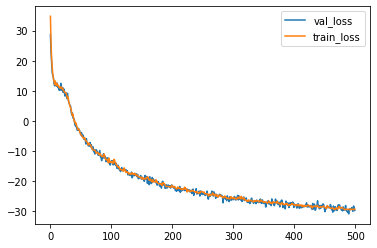

In [38]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend(loc='best')